In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/My Drive/plant-seedlings-classification/train"
test_path = "/content/drive/My Drive/plant-seedlings-classification/test"

In [ ]:
import os
import os,glob
import cv2
import numpy as np
import pandas as pd

In [ ]:
from sklearn import preprocessing as skLearnPreprocess
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
def getPath (path):
  return glob.glob(path)

paths = getPath(train_path +"/*")

##  Read Images

In [ ]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(train_path):
    class_folder_path = os.path.join(train_path, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob.glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

## Resize images

In [ ]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [ ]:
classes = np.array(classes).reshape(-1,1)

In [ ]:
images = np.array(images)

## Label Encoding

In [ ]:
def encodeLabels(y_train, y_valid):
  le = skLearnPreprocess.LabelEncoder()
  y_train = le.fit_transform(y_train)
  y_valid = le.fit_transform(y_valid)
  y_train = tf.keras.utils.to_categorical(y_train, num_classes=12)
  y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=12)
  y_valid = np.array(y_valid)
  y_train = np.array(y_train)

  return y_train , y_valid

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(images, classes, test_size=0.2, random_state=42)

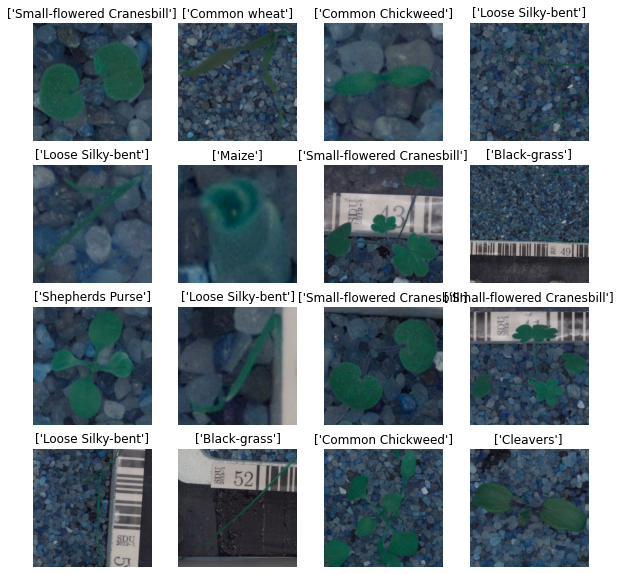

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_valid[i])
    plt.axis('off')
    plt.title(y_valid[i])
plt.show()

In [ ]:
y_train, y_valid = encodeLabels(y_train, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
def buildmodel():
    data_augmentation = keras.Sequential(
        [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
    )

    base_model = keras.applications.DenseNet201(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(224, 224, 3),
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.

    # Freeze the base_model
    base_model.trainable = False
    inputs = keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation

    # Pre-trained Xception weights requires that input be scaled
    # from (0, 255) to a range of (-1., +1.), the rescaling layer
    # outputs: `(inputs * scale) + offset`
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(x)

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(12,activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(
    optimizer= tf.keras.optimizers.Adam(epsilon=0.0001),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
    )
    
    return(model)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
model = buildmodel()
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid,y_valid),
    epochs=30,
    #callbacks=[early_stopping],
)

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/30
119/119 [==============================] - 55s 274ms/step - loss: 1.7087 - categorical_accuracy: 0.4468 - val_loss: 1.0562 - val_categorical_accuracy: 0.6811
Epoch 2/30
119/119 [==============================] - 21s 180ms/step - loss: 1.0050 - categorical_accuracy: 0.7126 - val_loss: 0.7636 - val_categorical_accuracy: 0.7832
Epoch 3/30
119/119 [==============================] - 22s 184ms/step - loss: 0.7925 - categorical_accuracy: 0.7755 - val_loss: 0.5993 - val_categorical_accuracy: 0.8337
Epoch 4/30
119/119 [==============================] - 22s 187ms/step - loss: 0.6757 - categorical_accuracy: 0.8084 - val_loss: 0.5361 - val_categorical_accuracy: 0.8432
Epoch 5/30
119/119 [==============================] - 22s 188ms/step - loss: 0.6025 - categorical_accuracy: 0.8239 - val_loss: 0.4827 - val_categorical_accuracy: 0.8642
Epoch 6/30
119/119 [==============================] - 22s 186ms/step - loss: 0.5427 - cate

In [ ]:
%matplotlib inline
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

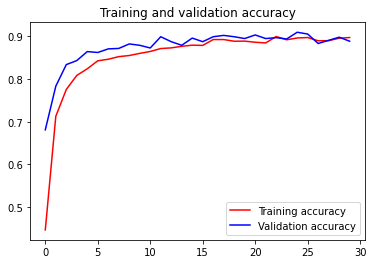

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

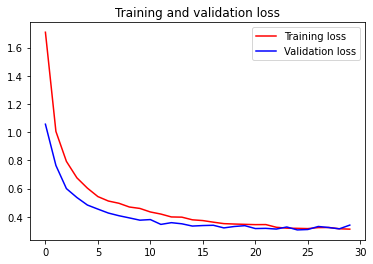

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
filenames = os.listdir(test_path)

In [ ]:
test_images = []
missing=0

for test_image_path in os.listdir(test_path):
  image_bgr = cv2.imread(os.path.join(test_path, test_image_path), cv2.IMREAD_COLOR)
  if image_bgr is None: # if the file contain any missing value ignore it
    missing += 1
    continue
  test_images.append(image_bgr)

In [ ]:
print(missing)
len(test_images)

0


804

In [ ]:
test_images = [resize_images(img) for img in test_images]
test_images = np.array(test_images)
preds_test = model.predict(test_images)
preds_test.shape

(804, 12)

In [ ]:
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]
class_list = []

for i in range(0, preds_test.shape[0]):
  y_class = preds_test[i, :].argmax(axis=-1)
  class_list += [species_list[y_class]]

print(class_list)

['Fat Hen', 'Small-flowered Cranesbill', 'Sugar beet', 'Common Chickweed', 'Sugar beet', 'Black-grass', 'Common Chickweed', 'Fat Hen', 'Loose Silky-bent', 'Loose Silky-bent', 'Small-flowered Cranesbill', 'Fat Hen', 'Loose Silky-bent', 'Sugar beet', 'Fat Hen', 'Sugar beet', 'Scentless Mayweed', 'Scentless Mayweed', 'Scentless Mayweed', 'Shepherds Purse', 'Common Chickweed', 'Common Chickweed', 'Small-flowered Cranesbill', 'Sugar beet', 'Shepherds Purse', 'Sugar beet', 'Maize', 'Scentless Mayweed', 'Scentless Mayweed', 'Common Chickweed', 'Common Chickweed', 'Shepherds Purse', 'Sugar beet', 'Loose Silky-bent', 'Loose Silky-bent', 'Loose Silky-bent', 'Common Chickweed', 'Sugar beet', 'Common Chickweed', 'Maize', 'Common wheat', 'Common Chickweed', 'Maize', 'Small-flowered Cranesbill', 'Sugar beet', 'Loose Silky-bent', 'Sugar beet', 'Loose Silky-bent', 'Scentless Mayweed', 'Maize', 'Cleavers', 'Fat Hen', 'Loose Silky-bent', 'Charlock', 'Loose Silky-bent', 'Maize', 'Sugar beet', 'Small-flow

In [ ]:
submission = pd.DataFrame()
submission['file'] = filenames
submission['species'] = class_list

submission.to_csv('submission.csv', index=False)